In [2]:
%load_ext autoreload
%autoreload 2

Load eight schools data from posteriordb

In [3]:
from posteriordb import PosteriorDatabase

pdb_path = "/workspaces/jupyter-data/posteriordb/posterior_database/"
my_pdb = PosteriorDatabase(pdb_path)

In [4]:
set(my_pdb.dataset_names()) & set(my_pdb.model_names())

{'arK',
 'diamonds',
 'dogs',
 'gp_pois_regr',
 'hmm_example',
 'irt_2pl',
 'low_dim_gauss_mix',
 'low_dim_gauss_mix_collapse',
 'mesquite',
 'one_comp_mm_elim_abs',
 'pilots',
 'sir'}

# Diamonds

In [4]:
model_name = "diamonds"
model = my_pdb.model(model_name)
data = my_pdb.data(model_name)

In [5]:
print(model.stan_code())

// generated with brms 2.10.0

functions {
}
data {
  int<lower=1> N;  // number of observations
  vector[N] Y;  // response variable
  int<lower=1> K;  // number of population-level effects
  matrix[N, K] X;  // population-level design matrix
  int prior_only;  // should the likelihood be ignored?
}
transformed data {
  int Kc = K - 1;
  matrix[N, Kc] Xc;  // centered version of X without an intercept
  vector[Kc] means_X;  // column means of X before centering
  for (i in 2:K) {
    means_X[i - 1] = mean(X[, i]);
    Xc[, i - 1] = X[, i] - means_X[i - 1];
  }
}
parameters {
  vector[Kc] b;  // population-level effects
  // temporary intercept for centered predictors
  real Intercept;
  real<lower=0> sigma;  // residual SD
}
transformed parameters {
}
model {
  // priors including all constants
  target += normal_lpdf(b | 0, 1);
  target += student_t_lpdf(Intercept | 3, 8, 10);
  target += student_t_lpdf(sigma | 3, 0, 10)
    - 1 * student_t_lccdf(0 | 3, 0, 10);
  // likelihood includ

In [6]:
import torch
import torch.distributions as dist

import beanmachine.ppl as bm
import beanmachine.ppl.distribution.flat


@bm.random_variable
def N():
    return beanmachine.ppl.distribution.flat.Flat([])


@bm.random_variable
def k():
    return beanmachine.ppl.distribution.flat.Flat([])


@bm.random_variable
def x():
    return beanmachine.ppl.distribution.flat.Flat((5000, 25))


@bm.random_variable
def beta():
    return dist.Independent(
        dist.Normal(
            torch.zeros(k().int().item() - 1), torch.ones(k().int().item() - 1)
        ),
        1,
    )


@bm.random_variable
def alpha():
    return dist.StudentT(df=3, loc=8, scale=10)


@bm.random_variable
def sigma():
    return dist.HalfCauchy(scale=10)


@bm.random_variable
def y():
    return dist.Independent(dist.Normal(alpha() + x() @ beta().T, sigma()), 1)

In [7]:
import os
from datetime import datetime, timedelta, timezone

import numpy as np
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
from tqdm.auto import tqdm

import flowtorch.bijectors
from beanmachine.ppl.experimental.vi.variational_infer import (
    MeanFieldVariationalInference,
)
from beanmachine.ppl.world import World

queries = [alpha(), beta(), sigma()]
obs = {
    y(): torch.tensor(data.values()["Y"]),
    N(): torch.tensor(data.values()["N"]).float(),
    k(): torch.tensor(data.values()["K"]).float(),
    x(): (
        torch.tensor(data.values()["X"]) - torch.tensor(data.values()["X"]).mean(dim=0)
    )[:, 1:],
}


def y_marginal(vi_dicts, num_samples=100):
    y_rvid = y()
    probs = []
    for _ in range(num_samples):
        with World() as w:
            w.vi_dicts = vi_dicts
            w.observations_ = obs

            for rvid in queries + list(obs.keys()):
                w.call(rvid)
            probs.append(w.get_node_in_world(y_rvid).log_prob.item())
    return np.array(probs).mean()


def on_iter(it, _, loss, vi_dicts):
    if it % 10 == 0:
        tqdm.write(f"Loss: {loss}", end='')
        writer.add_scalar("ELBO", -loss, global_step=it)
        writer.add_scalar("y_marginal", y_marginal(vi_dicts), global_step=it)
        try:
            writer.add_scalars(
                "beta() DoF", 
                {
                    f"beta_{k}":v
                    for k, v in enumerate(vi_dicts(beta()).new_dist.base_dist.base_dist.df)
                }, 
                global_step=it)
        except AttributeError as e:
            #raise e
            pass

for name, flow in [
    ("MAF", lambda: flowtorch.bijectors.AffineAutoregressive()),
    #("IAF", lambda: flowtorch.bijectors.AffineAutoregressive().inv()),
    ("MAF-2L", lambda: flowtorch.bijectors.Compose([
        flowtorch.bijectors.AffineAutoregressive(),
        flowtorch.bijectors.AffineAutoregressive(),
    ])),
    ("MAF-3L", lambda: flowtorch.bijectors.Compose([
        flowtorch.bijectors.AffineAutoregressive(),
        flowtorch.bijectors.AffineAutoregressive(),
        flowtorch.bijectors.AffineAutoregressive(),
    ])),
    ("ADVI", lambda: flowtorch.bijectors.Compose([])),
]:
#     for ht in ['HT']:
    for ht in ['', 'HT']:
        if ht == 'HT':
            name += '_HT'
            
        for trial in range(1):
            lr = 1e-3
            current_time = datetime.now(timezone(timedelta(hours=-8))).strftime("%b%d_%H-%M-%S")
            rundir = f"{current_time}_{model_name}_{name}_lr={lr}"
            logdir = os.path.join("/workspaces/jupyter-data/logdir", rundir)
            writer = SummaryWriter(log_dir=logdir)
            print(logdir)

            batch_size = 10
            vi_dicts = None
            for epoch in tqdm(range(10001)):
                idx = epoch * batch_size % len(data.values()["Y"])
                kwargs = {}
                if ht == 'HT':
                    kwargs = {
                        'base_dist': dist.StudentT,
                        'base_args': {
                            'df': nn.Parameter(torch.tensor([50.0]).log()),
                            'loc': nn.Parameter(torch.tensor([0.0])),
                            'scale': nn.Parameter(torch.tensor([1.0])),
                        }
                    }
                vi_dicts = MeanFieldVariationalInference().infer(
                    queries=queries,
                    observations={
                        y(): torch.tensor(data.values()["Y"][idx:idx+batch_size]),
                        N(): torch.tensor(data.values()["N"]).float(),
                        k(): torch.tensor(data.values()["K"]).float(),
                        x(): (
                            torch.tensor(data.values()["X"][idx:idx+batch_size]) - torch.tensor(data.values()["X"]).mean(dim=0)
                        )[:, 1:],
                    },
                    num_iter=1,
                    on_iter=lambda _, loss, vid: on_iter(epoch, _, loss, vid),
                    lr=lr,
                    num_elbo_mc_samples=1,
                    flow=flow,
                    vi_dicts = vi_dicts,
                    **kwargs
                )
            writer.close()

/workspaces/jupyter-data/logdir/May26_16-24-53_diamonds_MAF_lr=0.001


/workspaces/jupyter-data/flowtorch/flowtorch/params/dense_autoregressive.py:160: UserWarning: DenseAutoregressive input_dim = 1. Consider using an affine transformation instead.
  warnings.warn(


Loss: tensor([190.9803], grad_fn=<SubBackward0>)
/workspaces/jupyter-data/logdir/May26_17-08-16_diamonds_MAF_HT_lr=0.001


Loss: tensor([210.2149], grad_fn=<SubBackward0>))>)
/workspaces/jupyter-data/logdir/May26_17-53-59_diamonds_MAF-2L_lr=0.001


Loss: tensor([198.0389], grad_fn=<SubBackward0>)>)
/workspaces/jupyter-data/logdir/May26_18-49-32_diamonds_MAF-2L_HT_lr=0.001


Loss: tensor([221.0941], grad_fn=<SubBackward0>)d0>)
/workspaces/jupyter-data/logdir/May26_19-46-23_diamonds_MAF-3L_lr=0.001


Loss: tensor([207.1049], grad_fn=<SubBackward0>)d0>)
/workspaces/jupyter-data/logdir/May26_20-51-08_diamonds_MAF-3L_HT_lr=0.001


Loss: tensor([204.8841], grad_fn=<SubBackward0>)0>)
/workspaces/jupyter-data/logdir/May26_21-57-16_diamonds_ADVI_lr=0.001


Loss: tensor([396.3325], grad_fn=<SubBackward0>)))))
/workspaces/jupyter-data/logdir/May26_22-36-07_diamonds_ADVI_HT_lr=0.001


Loss: tensor([404.2834], grad_fn=<SubBackward0>)))))


In [9]:
import glob

import pandas as pd
import tensorflow as tf
from tensorflow.python.summary.summary_iterator import summary_iterator

data = []
for summary_path in glob.glob('./logdir/*/events.out.tfevents.*'):
    if not "diamonds" in summary_path:
        continue
    name = '_'.join(summary_path.split('/')[2].split('_')[2:5])
    if '_HT' not in name:
        name = '_'.join(name.split('_')[:-1])
    dataset, name = name.split('_')[0], '_'.join(name.split('_')[1:])
    for event in summary_iterator(summary_path):
        if event.step != 10000:
            continue
        data.append({
            'name': name,
            'dataset': dataset,
            'step': 10000,
            'tag': event.summary.value[0].tag,
            'value': event.summary.value[0].simple_value,
        })
df = pd.DataFrame(data)

In [10]:
df

,name,dataset,step,tag,value
0,MAF-3L_HT,diamonds,10000,ELBO,-209.794220
1,MAF-3L_HT,diamonds,10000,y_marginal,-7128.079102
2,MAF,diamonds,10000,ELBO,-190.980301
3,MAF,diamonds,10000,y_marginal,-6681.983398
4,MAF_HT,diamonds,10000,ELBO,-218.893188
5,MAF_HT,diamonds,10000,y_marginal,-8074.510254
6,ADVI_HT,diamonds,10000,ELBO,-199.876175
7,ADVI_HT,diamonds,10000,y_marginal,-6887.317871
8,ADVI,diamonds,10000,ELBO,-374.397400
9,ADVI,diamonds,10000,y_marginal,-16845.755859


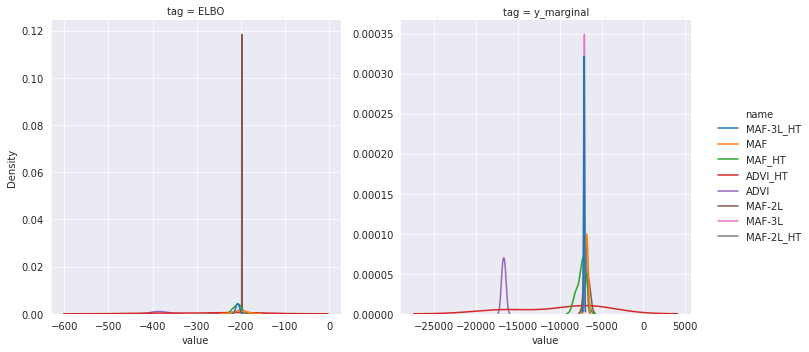

In [11]:
import seaborn as sns

sns.set_style('darkgrid')

sns.displot(
    data=df, x='value', hue='name', col='tag', kind='kde',
    facet_kws={'sharex': False, 'sharey': False}
)

In [12]:
df.groupby(['name', 'tag']).mean()

step         value
name      tag                            
ADVI      ELBO        10000   -385.364929
          y_marginal  10000 -16694.190430
ADVI_HT   ELBO        10000   -272.639921
          y_marginal  10000 -10165.867676
MAF       ELBO        10000   -201.016579
          y_marginal  10000  -6788.399658
MAF-2L    ELBO        10000   -197.949493
          y_marginal  10000  -6745.940918
MAF-2L_HT ELBO        10000   -206.504311
          y_marginal  10000  -6952.569336
MAF-3L    ELBO        10000   -200.617775
          y_marginal  10000  -7057.626953
MAF-3L_HT ELBO        10000   -207.339149
          y_marginal  10000  -7095.178711
MAF_HT    ELBO        10000   -208.939980
          y_marginal  10000  -7383.710327

In [13]:
df[df['value'].abs() < 10000].groupby(['name', 'tag']).std()

step       value
name      tag                         
ADVI      ELBO         0.0   15.510429
ADVI_HT   ELBO         0.0   93.939025
          y_marginal   0.0  242.752214
MAF       ELBO         0.0   14.193440
          y_marginal   0.0  150.495318
MAF-2L    ELBO         0.0    0.126454
          y_marginal   0.0  301.964979
MAF-2L_HT ELBO         0.0   20.633123
          y_marginal   0.0  159.326211
MAF-3L    ELBO         0.0    9.174121
          y_marginal   0.0   42.909781
MAF-3L_HT ELBO         0.0    3.471994
          y_marginal   0.0   46.528179
MAF_HT    ELBO         0.0    7.526883
          y_marginal   0.0  481.450207

In [75]:
df[df['name'] == 'MAF_HT']

,name,step,tag,value
32,MAF_HT,5000,ELBO,-65.371246
33,MAF_HT,5000,y_marginal,-55.972523


# Low Dim Gauss Mix

In [68]:
model_name = "low_dim_gauss_mix"
model = my_pdb.model(model_name)
data = my_pdb.data(model_name)

In [75]:
import torch
import torch.distributions as dist

import beanmachine.ppl as bm
import beanmachine.ppl.distribution.flat


@bm.random_variable
def N():
    return beanmachine.ppl.distribution.flat.Flat([])


@bm.random_variable
def mu():
    return dist.Independent(dist.Normal(torch.zeros(2), 2 * torch.ones(2)), 1)


@bm.random_variable
def sigma():
    return dist.Independent(dist.HalfNormal(2 * torch.ones(2)), 1)


@bm.random_variable
def theta():
    return dist.Beta(5, 5)


@bm.random_variable
def y():
    return dist.MixtureSameFamily(
        dist.Categorical(
            torch.tensor([theta().item(), torch.ones(1) - theta().item()])
        ),
        dist.Normal(mu(), sigma()),
    )

In [213]:
import os
from datetime import datetime, timedelta, timezone

import numpy as np
import torch.nn as nn
from tensorboardX import SummaryWriter

import flowtorch.bijectors
from beanmachine.ppl.experimental.vi.variational_infer import (
    MeanFieldVariationalInference,
)
from beanmachine.ppl.world import World

queries = [mu(), sigma(), theta()]
obs = {
    y(): torch.tensor(data.values()["y"]).float(),
}


def y_marginal(vi_dicts, num_samples=100):
    y_rvid = y()
    probs = []
    for _ in range(num_samples):
        with World() as w:
            w.vi_dicts = vi_dicts
            w.observations_ = obs

            for rvid in queries + list(obs.keys()):
                w.call(rvid)
            probs.append(w.get_node_in_world(y_rvid).log_prob.item())
    return np.array(probs).mean()

for name, flow in [
#      ("MAF", lambda: flowtorch.bijectors.AffineAutoregressive(
#          flowtorch.params.DenseAutoregressive(hidden_dims=(16,)),
#      )),
    ("IAF", lambda: flowtorch.bijectors.AffineAutoregressive(
        flowtorch.params.DenseAutoregressive(hidden_dims=(16,)),
    ).inv()),
    ("ADVI", lambda: flowtorch.bijectors.Compose([])),
]:
    current_time = datetime.now(timezone(timedelta(hours=-8))).strftime("%b%d_%H-%M-%S")
    rundir = f"{current_time}_{model_name}_{name}"
    logdir = os.path.join("/workspaces/jupyter-data/logdir", rundir)
    writer = SummaryWriter(logdir=logdir)
    
    
    def on_iter(it, _, loss, vi_dicts):
        if it % 100 == 0:
            tqdm.write(f"Loss: {loss}", end='')
            writer.add_scalar("ELBO", -loss, global_step=it)
            writer.add_scalar("y_marginal", y_marginal(vi_dicts), global_step=it)

    vi_dicts = None
    vi_dicts = MeanFieldVariationalInference().infer(
        queries=queries,
        observations={
            y(): torch.tensor(data.values()["y"]).float(),
        },
        num_iter=1001,
        on_iter=None,
        lr=5e-2,
        num_elbo_mc_samples=100,
        flow=flow,
        vi_dicts=vi_dicts,
        pretrain=True,
    )
    for epoch in tqdm(range(5001)):
        batch_size = 1
        idx = epoch * batch_size % len(data.values()["y"])
        vi_dicts = MeanFieldVariationalInference().infer(
            queries=queries,
            observations={
                y(): torch.tensor(data.values()["y"][idx:idx+batch_size]).float(),
            },
            #num_iter=5001,
            num_iter=1,
            on_iter=lambda _, loss, vid: on_iter(epoch, _, loss, vid),
            lr=1e-3,
            num_elbo_mc_samples=1,
            flow=flow,
            vi_dicts=vi_dicts,
            pretrain=False,
        )

Loss: tensor([47.9788], grad_fn=<SubBackward0>))


Loss: tensor([12.6373], grad_fn=<SubBackward0>))


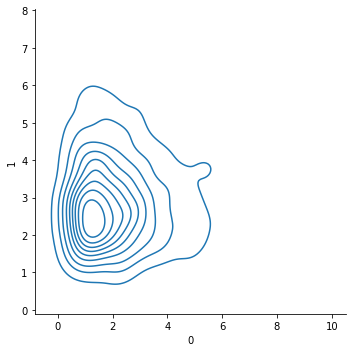

In [200]:
import seaborn as sns
import pandas as pd


df = pd.DataFrame(vi_dicts(sigma()).rsample((1000,)).detach().numpy())
sns.displot(
    data=df,
    kind='kde',
    x=0,
    y=1,
)

In [131]:
df.min()

0    0.000326
1    0.000060
dtype: float32

In [132]:
df.max()

0    14097.623047
1     2172.437744
dtype: float32

# Eight Schools

In [5]:
model_name = "eight_schools"
model = my_pdb.model(f"{model_name}_centered")
data = my_pdb.data(model_name)

In [9]:
print(model.code('stan'))

data {
  int <lower=0> J; // number of schools
  real y[J]; // estimated treatment
  real<lower=0> sigma[J]; // std of estimated effect
}
parameters {
  real theta[J]; // treatment effect in school j
  real mu; // hyper-parameter of mean
  real<lower=0> tau; // hyper-parameter of sdv
}
model {
  tau ~ cauchy(0, 5); // a non-informative prior
  theta ~ normal(mu, tau);
  y ~ normal(theta, sigma);
  mu ~ normal(0, 5);
}



In [12]:
data.values()

{'J': 8,
 'y': [28, 8, -3, 7, -1, 1, 18, 12],
 'sigma': [15, 10, 16, 11, 9, 11, 10, 18]}

In [10]:
import torch
import torch.distributions as dist

import beanmachine.ppl as bm
import beanmachine.ppl.distribution.flat


@bm.random_variable
def J():
    return beanmachine.ppl.distribution.flat.Flat([])


@bm.random_variable
def sigma():
    return beanmachine.ppl.distribution.flat.Flat((J().int().item(),))


@bm.random_variable
def mu():
    return dist.Normal(0, 5)


@bm.random_variable
def tau():
    return dist.HalfCauchy(5.0)


@bm.random_variable
def theta():
    J_int = J().int().item()
    if tau().dim() > 0:
        cov = (
            tau()
            .kron(torch.eye(J().int().item()))
            .reshape(tau().shape[0], J_int, J_int)
        )
    else:
        cov = tau() * torch.eye(J().int().item())
    try:
        d = dist.MultivariateNormal(mu() * torch.ones(J().int().item()), cov)
    except Exception as e:
        print(e)
        print(tau())
        print(cov)
    return d


@bm.random_variable
def y():
    return dist.MultivariateNormal(theta(), torch.diag(sigma()))

In [86]:
import numpy as np

from beanmachine.ppl.world import World


def y_marginal(vi_dicts, num_samples=100):
    queries = [mu(), theta(), tau()]
    obs = {
        sigma(): torch.tensor(data.values()["sigma"]).float(),
        y(): torch.tensor(data.values()["y"]).float(),
        J(): torch.tensor(data.values()["J"]).float(),
    }
    y_rvid = y()

    probs = []
    for _ in range(num_samples):
        with World() as w:
            w.vi_dicts = vi_dicts
            w.observations_ = obs

            for rvid in queries + list(obs.keys()):
                w.call(rvid)
            probs.append(w.get_node_in_world(y_rvid).log_prob.item())
    return np.array(probs).mean()

In [87]:
import os
from datetime import datetime, timedelta, timezone


from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn
from tqdm.auto import tqdm

import flowtorch.bijectors
from beanmachine.ppl.experimental.vi.variational_infer import (
    MeanFieldVariationalInference,
)


def on_iter(it, _, loss, vi_dicts):
    if it % 100 == 0:
        tqdm.write(f"Loss: {loss}", end='')
        writer.add_scalar("ELBO", -loss, global_step=it)
        writer.add_scalar("y_marginal", y_marginal(vi_dicts), global_step=it)

results = []

for name, flow in [
#     ("MAF", lambda: flowtorch.bijectors.AffineAutoregressive()),
#     ("IAF", lambda: flowtorch.bijectors.AffineAutoregressive().inv()),
#     ("MAF-2L", lambda: flowtorch.bijectors.Compose([
#         flowtorch.bijectors.AffineAutoregressive(),
#         flowtorch.bijectors.AffineAutoregressive(),
#     ])),
#     ("IAF-2L", lambda: flowtorch.bijectors.Compose([
#         flowtorch.bijectors.AffineAutoregressive()
#         for _ in range(2)
#     ]).inv()),
#     ("MAF-3L", lambda: flowtorch.bijectors.Compose([
#         flowtorch.bijectors.AffineAutoregressive()
#         for _ in range(3)
#     ])),
#     ("IAF-3L", lambda: flowtorch.bijectors.Compose([
#         flowtorch.bijectors.AffineAutoregressive()
#         for _ in range(3)
#     ]).inv()),
    ("ADVI", lambda: flowtorch.bijectors.Compose([])),
]:
    for ht in ['', 'HT']:
        if ht == 'HT':
            name += '_HT'
            
        for trial in range(10):
            current_time = datetime.now(timezone(timedelta(hours=-8))).strftime("%b%d_%H-%M-%S")
            rundir = f"{current_time}_{model_name}_{name}"
            logdir = os.path.join("/workspaces/jupyter-data/logdir", rundir)
            writer = SummaryWriter(logdir)

            vi_dicts = None
            for epoch in tqdm(range(5001)):
                kwargs = {}
                if ht == 'HT':
                    kwargs = {
                        'base_dist': dist.StudentT,
                        'base_args': {
                            'df': nn.Parameter(torch.tensor([5.0])),
                            'loc': nn.Parameter(torch.tensor([0.0])),
                            'scale': nn.Parameter(torch.tensor([1.0])),
                        }
                    }
                vi_dicts = MeanFieldVariationalInference().infer(
                    queries=[theta(), mu(), tau()],
                    observations={
                        sigma(): torch.tensor(data.values()["sigma"]).float(),
                        y(): torch.tensor(data.values()["y"]).float(),
                        J(): torch.tensor(data.values()["J"]).float(),
                    },
                    #num_iter=5001,
                    #on_iter=on_iter,
                    num_iter=1,
                    on_iter=lambda _, loss, vid: on_iter(epoch, _, loss, vid),
                    lr=1e-3,
                    flow=flow,
                    num_elbo_mc_samples=1,
                    vi_dicts=vi_dicts,
                    **kwargs
                )
            writer.close()
            results.append({
                'name': name,
                'trial': trial,
                'marg_lik': y_marginal(vi_dicts),
            })

Loss: tensor([121.0766], grad_fn=<SubBackward0>)))


Loss: tensor([423.3439], grad_fn=<SubBackward0>)))


Loss: tensor([110.9093], grad_fn=<SubBackward0>)))


Loss: tensor([119.2081], grad_fn=<SubBackward0>))


Loss: tensor([117.7901], grad_fn=<SubBackward0>)))


Loss: tensor([160.1169], grad_fn=<SubBackward0>))


Loss: tensor([236.1416], grad_fn=<SubBackward0>))


Loss: tensor([199.8533], grad_fn=<SubBackward0>))


Loss: tensor([110.9402], grad_fn=<SubBackward0>))


Loss: tensor([339.1783], grad_fn=<SubBackward0>))


Loss: tensor([106.0344], grad_fn=<SubBackward0>)))


Loss: tensor([7850.2808], grad_fn=<SubBackward0>))


Loss: tensor([113.2857], grad_fn=<SubBackward0>)))


Loss: tensor([110.5633], grad_fn=<SubBackward0>))


Loss: tensor([126.1821], grad_fn=<SubBackward0>)))


Loss: tensor([114.6889], grad_fn=<SubBackward0>)>)


Loss: tensor([627.3849], grad_fn=<SubBackward0>)))


Loss: tensor([167.8289], grad_fn=<SubBackward0>)))


Loss: tensor([117.8010], grad_fn=<SubBackward0>)))


Loss: tensor([115.9389], grad_fn=<SubBackward0>)))


In [88]:
import glob

import pandas as pd
import tensorflow as tf
from tensorflow.python.summary.summary_iterator import summary_iterator

data = []
for summary_path in glob.glob('./logdir/*/events.out.tfevents.*'):
    name = '_'.join(summary_path.split('/')[2].split('_')[4:6])
    for event in summary_iterator(summary_path):
        if event.step != 5000:
            continue
        data.append({
            'name': name,
            'step': 5000,
            'tag': event.summary.value[0].tag,
            'value': event.summary.value[0].simple_value,
        })
df = pd.DataFrame(data)

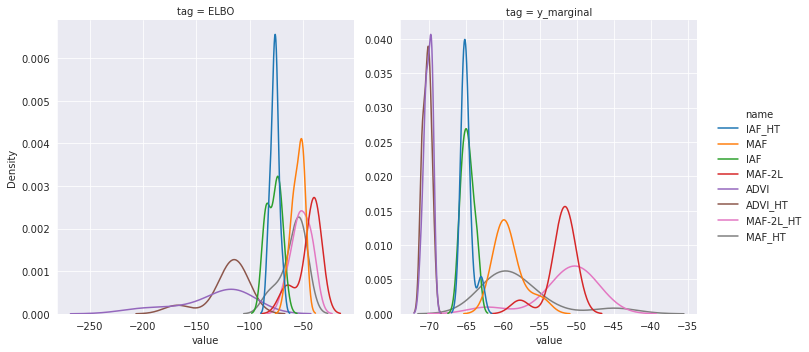

In [96]:
import seaborn as sns

sns.set_style('darkgrid')

sns.displot(
    data=df[df['value'].abs() < 200], x='value', hue='name', col='tag', kind='kde',
    facet_kws={'sharex': False, 'sharey': False}
)

In [101]:
df[df['value'].abs() < 200].groupby(['name', 'tag']).mean()

step       value
name      tag                         
ADVI      ELBO        5000 -134.270648
          y_marginal  5000  -70.112595
ADVI_HT   ELBO        5000 -121.540408
          y_marginal  5000  -70.288544
IAF       ELBO        5000  -77.672712
          y_marginal  5000  -64.794121
IAF_HT    ELBO        5000  -76.665797
          y_marginal  5000  -64.912134
MAF       ELBO        5000  -55.063180
          y_marginal  5000  -59.168514
MAF-2L    ELBO        5000  -45.015249
          y_marginal  5000  -52.193479
MAF-2L_HT ELBO        5000  -51.675030
          y_marginal  5000  -51.531240
MAF_HT    ELBO        5000  -59.631966
          y_marginal  5000  -57.845649

In [100]:
df[df['value'].abs() < 200].groupby(['name', 'tag']).std()

step      value
name      tag                        
ADVI      ELBO         0.0  33.495622
          y_marginal   0.0   0.517765
ADVI_HT   ELBO         0.0  19.586988
          y_marginal   0.0   0.541315
IAF       ELBO         0.0   6.473867
          y_marginal   0.0   0.795502
IAF_HT    ELBO         0.0   3.705401
          y_marginal   0.0   0.761531
MAF       ELBO         0.0   5.455337
          y_marginal   0.0   1.993199
MAF-2L    ELBO         0.0  11.021414
          y_marginal   0.0   2.057984
MAF-2L_HT ELBO         0.0   8.724683
          y_marginal   0.0   4.225512
MAF_HT    ELBO         0.0  11.544552
          y_marginal   0.0   4.970379

In [75]:
df[df['name'] == 'MAF_HT']

,name,step,tag,value
32,MAF_HT,5000,ELBO,-65.371246
33,MAF_HT,5000,y_marginal,-55.972523


## ADVI using Stan 

In [13]:
import os

from cmdstanpy import CmdStanModel, cmdstan_path, set_cmdstan_path

set_cmdstan_path("/root/.cmdstan/cmdstan-2.26.1/")
os.environ["TBB_CXX_TYPE"] = "gcc"
# stan_model = CmdStanModel(stan_file=model.stan_code_file_path())

ValueError: no such CmdStan directory /root/.cmdstan/cmdstan-2.26.1/

In [153]:
stan_model = CmdStanModel(stan_file=model.stan_code_file_path())
vb = stan_model.variational(data=data.values())

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /workspaces/jupyter-data/posteriordb/posterior_database/models/stan/eight_schools_centered
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


In [154]:
df = vb.variational_sample
df.columns = vb.column_names

<ipython-input-155-a924bd3e1f4c>:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  'mu': df.loc[:,'mu'][np.newaxis,:],
<ipython-input-155-a924bd3e1f4c>:5: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  'tau': df.loc[:,'tau'][np.newaxis,:],


array([[<AxesSubplot:title={'center':'theta\n0'}>,
        <AxesSubplot:title={'center':'theta\n1'}>,
        <AxesSubplot:title={'center':'theta\n2'}>],
       [<AxesSubplot:title={'center':'theta\n3'}>,
        <AxesSubplot:title={'center':'theta\n4'}>,
        <AxesSubplot:title={'center':'theta\n5'}>],
       [<AxesSubplot:title={'center':'theta\n6'}>,
        <AxesSubplot:title={'center':'theta\n7'}>,
        <AxesSubplot:title={'center':'mu'}>],
       [<AxesSubplot:title={'center':'tau'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

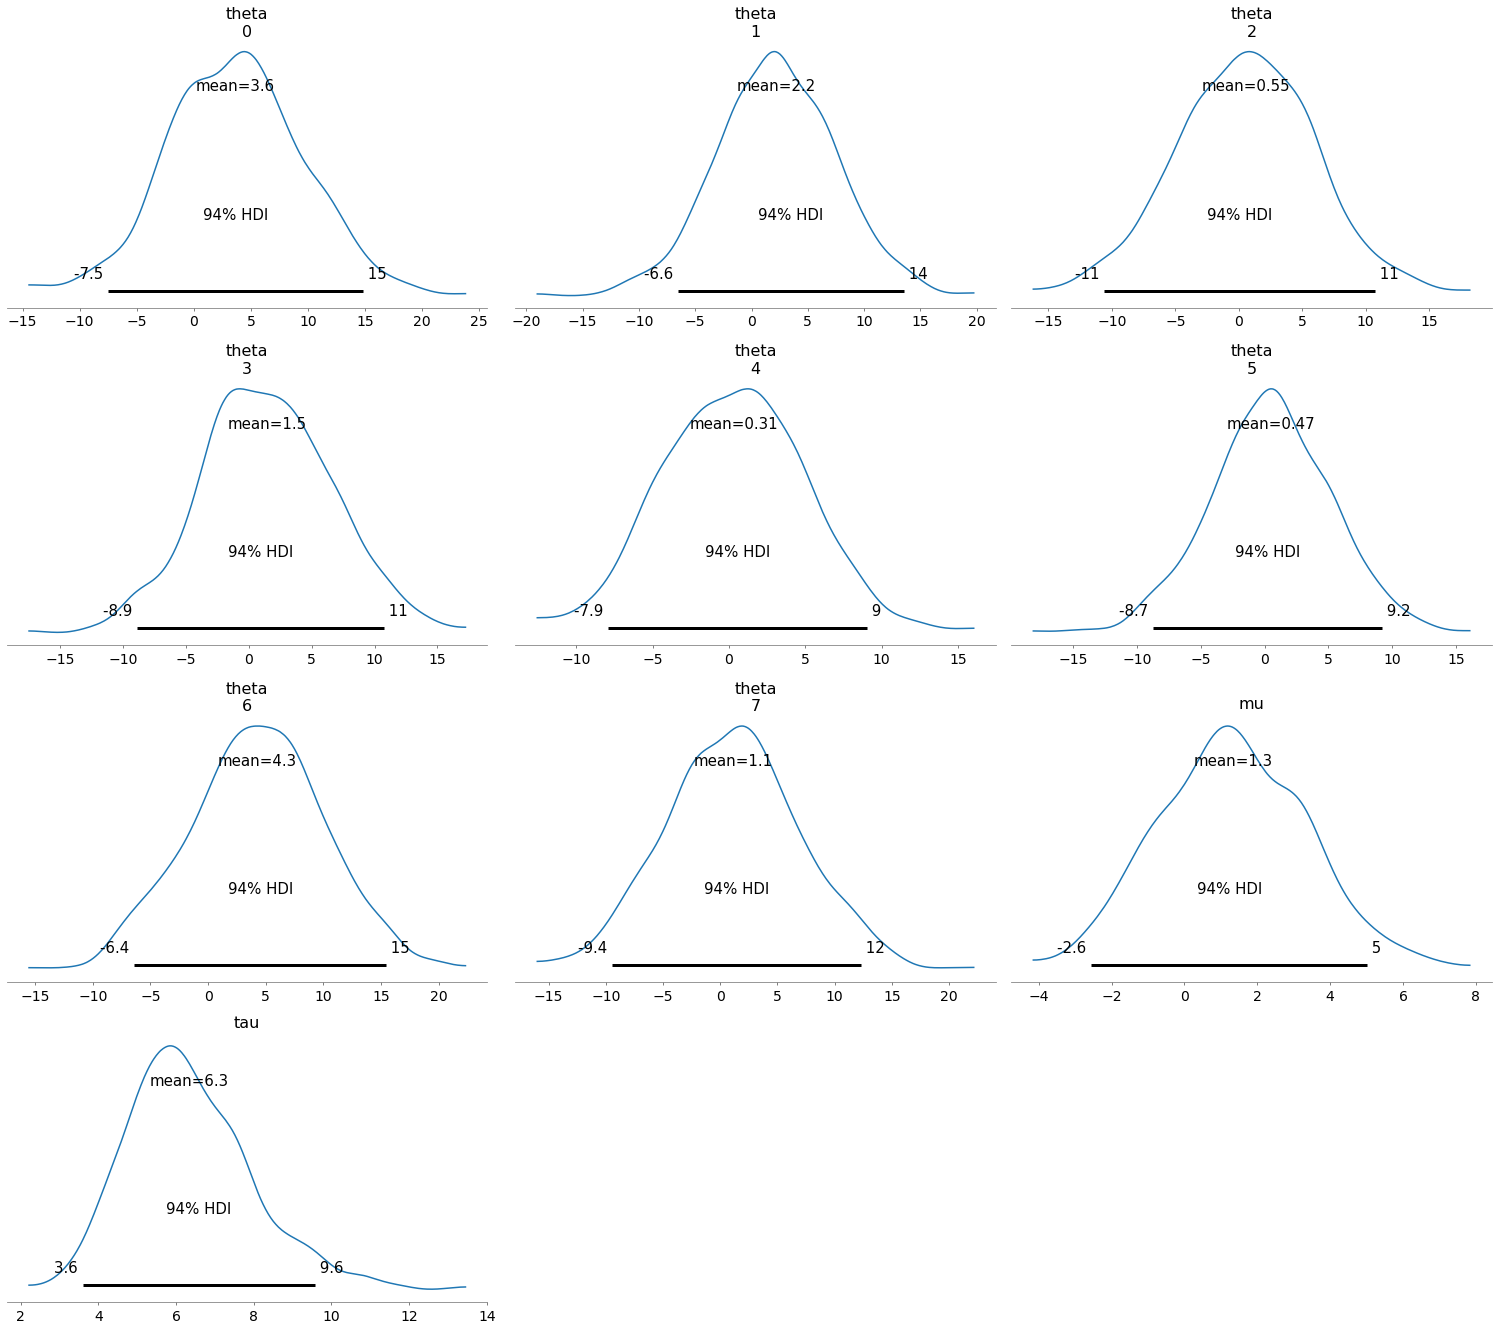

In [155]:
az.plot_posterior(
    az.convert_to_inference_data(
        {
            "theta": df.loc[:, map(lambda x: x.startswith("theta"), df.columns)].values[
                np.newaxis, :, :
            ],
            "mu": df.loc[:, "mu"][np.newaxis, :],
            "tau": df.loc[:, "tau"][np.newaxis, :],
        },
        coords={"school": np.arange(data.values()["J"])},
        dims={
            "theta": ["school"],
        },
    )
)  # , backend="bokeh")

## Reference samples (from Stan NUTS)

In [156]:
import arviz as az
import numpy as np

gs = my_pdb.posterior("eight_schools-eight_schools_centered").reference_draws()
gs_dict = {}
num_chains = len(gs)
num_samples = len(gs[0][next(iter(gs[0]))])

for i, chain in enumerate(gs):
    for var in chain:
        if "[" not in var:
            if var not in gs_dict:
                gs_dict[var] = np.zeros((num_chains, num_samples))
            gs_dict[var][i, :] = np.array(chain[var])
        else:
            name = var.split("[")[0]
            idx = int(var.split("[")[1].split("]")[0]) - 1
            if name not in gs_dict:
                var_size = len(list(filter(lambda x: x.startswith(name), chain)))
                gs_dict[name] = np.zeros((num_chains, num_samples, var_size))
            gs_dict[name][i, :, idx] = np.array(chain[var])

gs_idata = az.convert_to_inference_data(
    gs_dict,
    coords={"school": np.arange(data.values()["J"])},
    dims={
        "theta": ["school"],
    },
)

array([[<AxesSubplot:title={'center':'theta\n0'}>,
        <AxesSubplot:title={'center':'theta\n1'}>,
        <AxesSubplot:title={'center':'theta\n2'}>],
       [<AxesSubplot:title={'center':'theta\n3'}>,
        <AxesSubplot:title={'center':'theta\n4'}>,
        <AxesSubplot:title={'center':'theta\n5'}>],
       [<AxesSubplot:title={'center':'theta\n6'}>,
        <AxesSubplot:title={'center':'theta\n7'}>,
        <AxesSubplot:title={'center':'mu'}>],
       [<AxesSubplot:title={'center':'tau'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

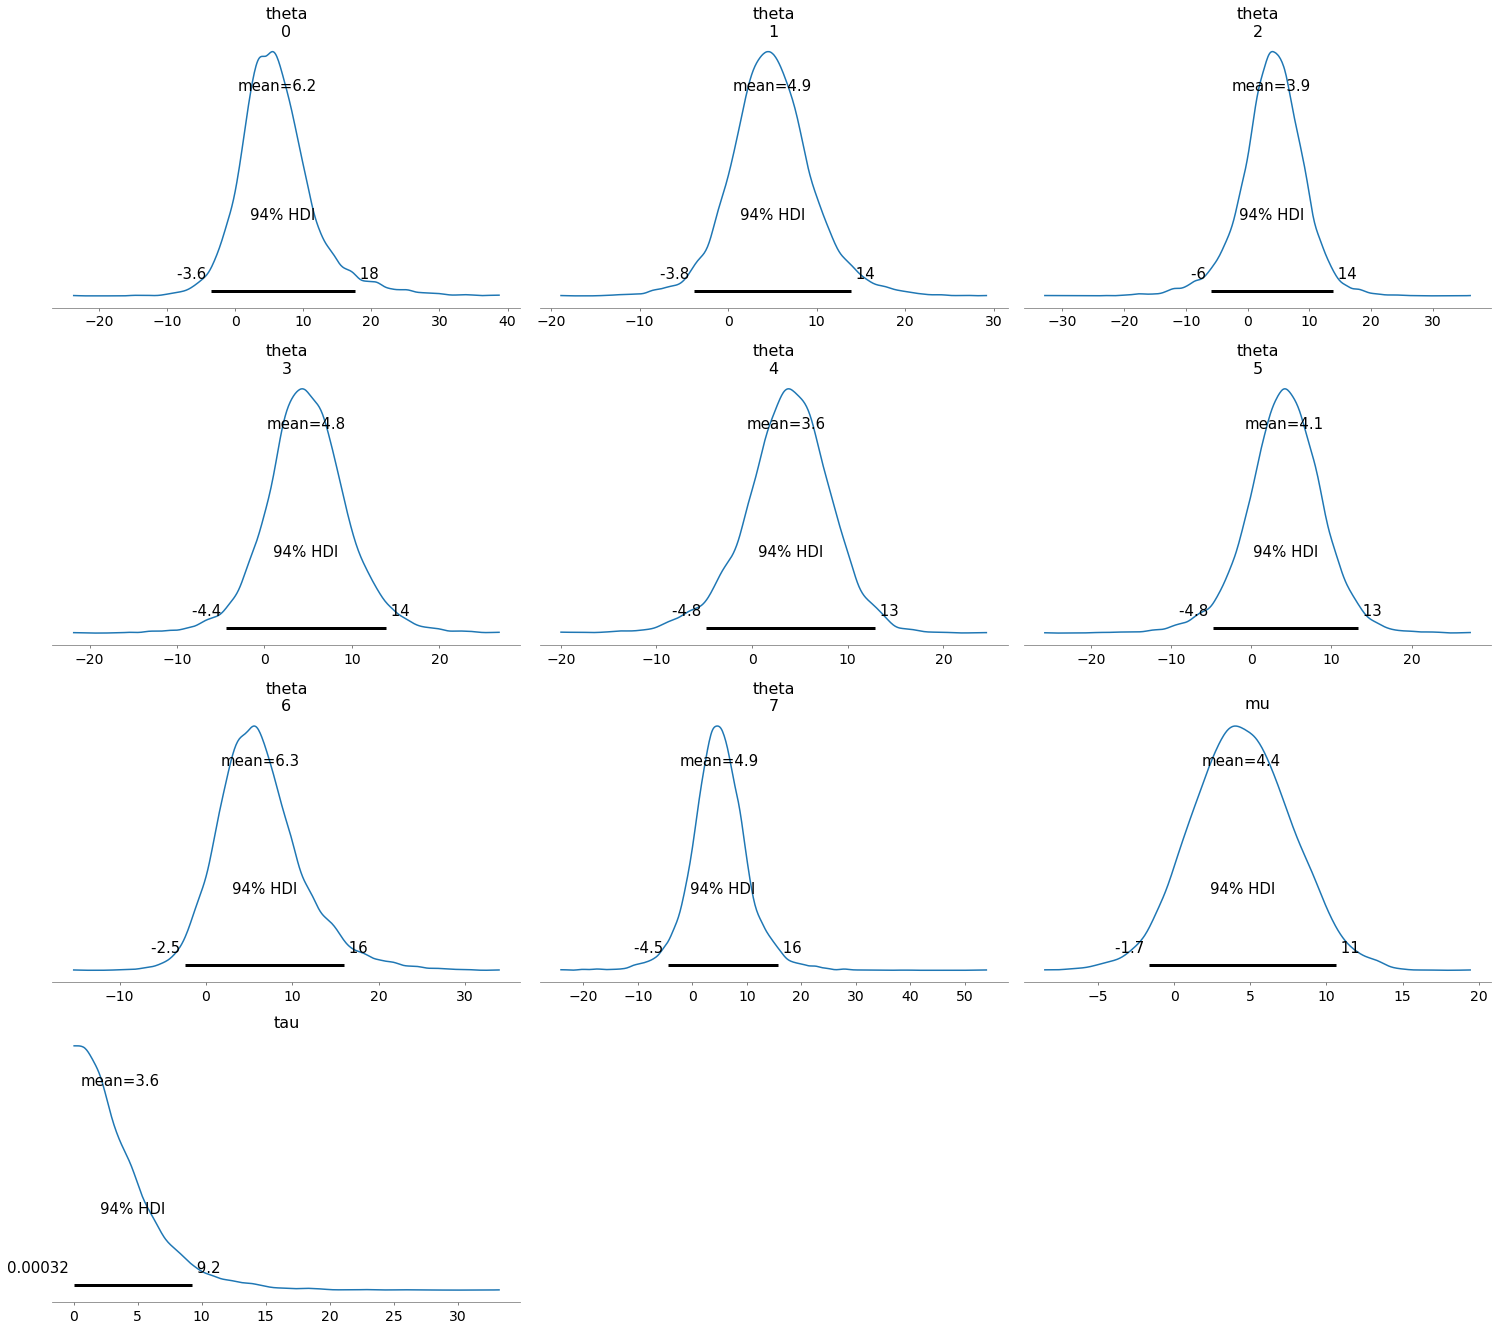

In [157]:
az.plot_posterior(gs_idata)  # , backend="bokeh")